---
# **Dependencies**
---

In [ ]:
#한글 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# h2o 설치
! apt-get install default-jre
!java -version
! pip install h2o

#런타임 다시 시작
import os
os.kill(os.getpid(), 9)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

---
# **Import Packages**
---

In [3]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')
mount_dir = '/content/drive/MyDrive/weather_con'

sns.set_style("white")
sns.set_context("talk")
plt.rc('font', family='NanumBarunGothic')

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

import plotly.io as pio
import plotly.express as px
pio.templates.default = "plotly_white"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import h2o
h2o.init()
from h2o.estimators import H2OTargetEncoderEstimator

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid import H2OGridSearch

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,13 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.4
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_1my9zh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.365 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


---
# **Import Data**
---

In [5]:
train_dt = pd.read_csv(mount_dir+'/train_data.csv', encoding='cp949', index_col=0)
train_dt['yyyymmdd'] = pd.to_datetime(train_dt['yyyymmdd'], format = '%Y-%m-%d')

test_dt = pd.read_csv(mount_dir+'/test_data.csv', encoding='cp949', index_col=0)
test_dt['yyyymmdd'] = pd.to_datetime(test_dt['yyyymmdd'], format = '%Y-%m-%d')
test_dt.drop(columns='frequency', inplace=True)

train_dt['log_sum_rn'] = np.log1p(train_dt['sum_rn'])
test_dt['log_sum_rn'] = np.log1p(test_dt['sum_rn'])

print(train_dt.shape, test_dt.shape)

(49674, 68) (12444, 64)


In [6]:
train = train_dt[train_dt['yyyymmdd'] < datetime(2015,7,1)]
valid = train_dt[train_dt['yyyymmdd'] >= datetime(2015,7,1)]

hf_train = h2o.H2OFrame(train)
hf_valid = h2o.H2OFrame(valid)
hf_test = h2o.H2OFrame(test_dt)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
# 분석 변수 분류
main_col2 = ['area', 'sex', 'weekday', 'is_firstday', 'is_holiday']
fore_col2 = ['예보최대기온', '예보최소기온', '예보평균기온', '최소예보습도', '평균예보습도', '예보풍속']
lag_col2 = ['1일 전 평균기온', '1일 전 최저기온', '1일 전 최고기온', '1일 전 평균풍속', '1일 전 평균이슬점온도', '1일 전 최소상대습도', '1일 전 평균상대습도', '1일 전 최고해면기압',
       '1일 전 최저해면기압', '1일 전 합계일조시간', '1일 전 일교차', '1일 전 기압차', '1일 전 SO2',  '1일 전 CO', '1일 전 O3', '1일 전 NO2', '1일 전 PM10']
acc_col2 = ['acc_causalty_1000pop']
pop_col2 = [ 'pop', 'old']
health_col2 = ['hpts_rate', 'dbts_rate', 'old_rate' ]
hospital_col2 = ['n_doctor_per1000pop', 'n_bed_per1000pop']

predictors = main_col2 + fore_col2 + lag_col2 + acc_col2 + pop_col2 + hospital_col2 + health_col2 + ['log_sum_rn']
response_col = 'frequency'
print(len(predictors))

37


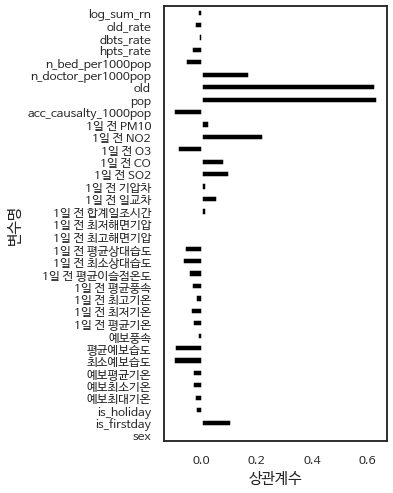

In [8]:
fig, ax = plt.subplots(figsize=(4, 8))
_ = pd.DataFrame(train_dt[predictors + [response_col]].corr()[response_col]).iloc[:-1].plot(kind='barh', ax=ax, colormap='gnuplot')
_.set_xlabel("상관계수", fontsize=15)
_.set_ylabel("변수명", fontsize=15)
_.tick_params(labelsize=12)
ax.get_legend().remove()

---
# **DRF Modeling**
---

### 🔵 max_depth grid search

In [9]:
drf_hp_10 = {  "max_depth": list(np.arange(1,29,1))  }
drf_sc_10 = {"strategy": "Cartesian" }
drf_model_10= H2ORandomForestEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
drf_grid_10= H2OGridSearch(model=drf_model_10, hyper_params=drf_hp_10, search_criteria=drf_sc_10, grid_id="drf_grid_10")
%time drf_grid_10.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 12.8 s, sys: 1.27 s, total: 14 s
Wall time: 26min 32s
      max_depth             model_ids  residual_deviance
0           9.0   drf_grid_10_model_9           1.474266
1           8.0   drf_grid_10_model_8           1.475020
2           7.0   drf_grid_10_model_7           1.479975
3          10.0  drf_grid_10_model_10           1.480278
4          11.0  drf_grid_10_model_11           1.481710
5           6.0   drf_grid_10_model_6           1.488600
6          12.0  drf_grid_10_model_12           1.495243
7          13.0  drf_grid_10_model_13           1.503343
8           5.0   drf_grid_10_model_5           1.505515
9          15.0  drf_grid_10_model_15           1.516175
10         14.0  drf_grid_10_model_14           1.516361
11          4.0   drf_grid_10_model_4           1.523713
12         16.0  drf_grid_10_model_16           1.535237
13         17.0  drf_grid_10_model_17

### max_depth 결과

In [10]:
drf_rmse_10 = drf_grid_10.sorted_metric_table()
drf_rmse_10['xval_rmse'] = np.sqrt(drf_rmse_10['residual_deviance'] )
drf_rmse_10['valid_rmse'] = pd.Series([drf_grid_10.models[i].rmse(valid=True) for i in list(np.arange(0,len(drf_rmse_10),1))])
drf_rmse_10.sort_values(by='valid_rmse', ascending=True)

,,max_depth,model_ids,residual_deviance,xval_rmse,valid_rmse
0,,9.0,drf_grid_10_model_9,1.474266,1.214194,1.227686
3,,10.0,drf_grid_10_model_10,1.480278,1.216667,1.228421
4,,11.0,drf_grid_10_model_11,1.481710,1.217255,1.228961
1,,8.0,drf_grid_10_model_8,1.475020,1.214504,1.230461
6,,12.0,drf_grid_10_model_12,1.495243,1.222801,1.231808
7,,13.0,drf_grid_10_model_13,1.503343,1.226109,1.234328
10,,14.0,drf_grid_10_model_14,1.516361,1.231406,1.234961
2,,7.0,drf_grid_10_model_7,1.479975,1.216542,1.235308
9,,15.0,drf_grid_10_model_15,1.516175,1.231331,1.236490
5,,6.0,drf_grid_10_model_6,1.488600,1.220082,1.236943


In [11]:
fig = px.scatter(drf_rmse_10, x='max_depth', y='valid_rmse',  width=300, height=250, color_discrete_sequence=['#0052cc'])
fig.update_layout(  font=dict(size=15) )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

### 🔵 mtries grid search
노이즈가 많은 데이터에서는 큰 값이 최적

In [13]:
drf_hp_11 =  {
                'mtries' : [14, 16, 18, 20, 22, 24, 30, 32, 34, 36],
                "max_depth": [9, 10, 11] 
                }
drf_sc_11 = {"strategy": "RandomDiscrete", 
                        "max_runtime_secs": 60*60*2,
                        "max_models": 200,
                        "stopping_metric": "RMSE",
                        "stopping_tolerance": 0.00001,
                        "stopping_rounds": 3
                        }

drf_model_11= H2ORandomForestEstimator(ntrees=100, nfolds=5, fold_assignment="random", score_each_iteration = True)
drf_grid_11= H2OGridSearch(model=drf_model_11, hyper_params=drf_hp_11, search_criteria=drf_sc_11, grid_id="drf_grid_110")
%time drf_grid_11.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 25.2 s, sys: 2.38 s, total: 27.6 s
Wall time: 50min 44s
      max_depth  mtries              model_ids  residual_deviance
0           9.0    18.0  drf_grid_110_model_21           1.470777
1           9.0    22.0  drf_grid_110_model_27           1.472397
2           9.0    14.0  drf_grid_110_model_11           1.472527
3           9.0    20.0   drf_grid_110_model_6           1.474241
4           9.0    16.0  drf_grid_110_model_25           1.474739
5           9.0    34.0   drf_grid_110_model_2           1.474773
6           9.0    24.0  drf_grid_110_model_16           1.477414
7          10.0    14.0  drf_grid_110_model_13           1.477465
8          10.0    16.0   drf_grid_110_model_8           1.477811
9          10.0    18.0  drf_grid_110_model_28           1.478403
10         10.0    20.0  drf_grid_110_model_15           1.479164
11          9.0    30.0  drf_grid_110_mod

### mtries 결과

In [14]:
drf_rmse_11 = drf_grid_11.sorted_metric_table()
drf_rmse_11['xval_rmse'] = np.sqrt(drf_rmse_11['residual_deviance'] )
drf_rmse_11['valid_rmse'] = pd.Series([drf_grid_11.models[i].rmse(valid=True) for i in list(np.arange(0,len(drf_rmse_11),1))])
drf_rmse_11.sort_values(by='valid_rmse', ascending=True)

,,max_depth,mtries,model_ids,residual_deviance,xval_rmse,valid_rmse
15,,10.0,24.0,drf_grid_110_model_17,1.485369,1.218757,1.226529
3,,9.0,20.0,drf_grid_110_model_6,1.474241,1.214183,1.226717
2,,9.0,14.0,drf_grid_110_model_11,1.472527,1.213477,1.226766
11,,9.0,30.0,drf_grid_110_model_18,1.481175,1.217035,1.226898
4,,9.0,16.0,drf_grid_110_model_25,1.474739,1.214388,1.227115
1,,9.0,22.0,drf_grid_110_model_27,1.472397,1.213423,1.227181
13,,9.0,36.0,drf_grid_110_model_24,1.482213,1.217462,1.227362
9,,10.0,18.0,drf_grid_110_model_28,1.478403,1.215896,1.227398
5,,9.0,34.0,drf_grid_110_model_2,1.474773,1.214402,1.227701
6,,9.0,24.0,drf_grid_110_model_16,1.477414,1.215489,1.227763


In [17]:
fig = px.scatter(drf_rmse_11, x='mtries', y='valid_rmse',  width=300, height=250, color_discrete_sequence=['#0052cc'])
fig.update_layout(  font=dict(size=15) )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

In [19]:
fig = px.scatter(drf_rmse_11, x='max_depth', y='valid_rmse',  width=300, height=250, color_discrete_sequence=['#0052cc'])
fig.update_layout(  font=dict(size=15) )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

In [53]:
fig = px.line(drf_rmse_11.sort_values(by=['max_depth' , 'mtries'], ascending=True).reset_index(drop=True), x='mtries', y='valid_rmse', color='max_depth', 
              color_discrete_sequence=['#0052cc', '#CC0052', '#00CC7A'],width=300, height=250)
fig.update_layout(  font=dict(size=15), showlegend=False )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

In [52]:
fig = px.line(drf_rmse_11.sort_values(by=['max_depth' , 'mtries'], ascending=True).reset_index(drop=True), x='mtries', y='valid_rmse', color='max_depth', 
              color_discrete_sequence=['#0052cc', '#CC0052', '#00CC7A'],width=500, height=350)
fig.update_layout(  font=dict(size=18), legend=dict( orientation="h", yanchor="top", y=1.5, xanchor="center", x=0.4, font=dict(size=15)) )
fig.update_xaxes( title_font = {"size": 23})
fig.update_yaxes( title_font = {"size": 23})
fig.show()

### 🔵 min_rows grid search
값이 작을수록 노이즈를 학습하는 경향이 있음.

In [25]:
drf_sc_012 = {"strategy": "RandomDiscrete", "max_runtime_secs": 60*60*3,"max_models": 200,"stopping_metric": "RMSE","stopping_tolerance": 0.00001,"stopping_rounds": 3}
drf_hp_012 =  {
                'mtries' : [24],
                "max_depth": [9] ,
                "min_rows" : [2, 4, 8, 16, 32, 64, 80, 100, 128, 160, 200, 256],
                'ntrees' : [100]
               #'sample_rate' : [0.7]
                }
drf_model_012= H2ORandomForestEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
drf_grid_012= H2OGridSearch(model=drf_model_012, hyper_params=drf_hp_012, search_criteria=drf_sc_012, grid_id="drf_grid_012")
%time drf_grid_012.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

drf_hp_012 =  {
                'mtries' : [20],
                "max_depth": [10] ,
                "min_rows" : [2, 4, 8, 16, 32, 64, 80, 100, 128, 160, 200, 256],
                'ntrees' : [100]
               # 'sample_rate' : [0.7]
                }
drf_model_012= H2ORandomForestEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
drf_grid_012= H2OGridSearch(model=drf_model_012, hyper_params=drf_hp_012, search_criteria=drf_sc_012, grid_id="drf_grid_012")
%time drf_grid_012.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 8.09 s, sys: 761 ms, total: 8.85 s
Wall time: 16min 40s
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 8.89 s, sys: 806 ms, total: 9.7 s
Wall time: 17min 42s
      max_depth  min_rows  mtries  ntrees              model_ids  \
0           9.0      16.0    24.0   100.0   drf_grid_012_model_2   
1           9.0       8.0    24.0   100.0   drf_grid_012_model_3   
2          10.0       8.0    20.0   100.0  drf_grid_012_model_16   
3          10.0      16.0    20.0   100.0  drf_grid_012_model_23   
4           9.0       2.0    24.0   100.0  drf_grid_012_model_11   
5          10.0       4.0    20.0   100.0  drf_grid_012_model_15   
6           9.0       4.0    24.0   100.0  drf_grid_012_model_10   
7           9.0      32.0    24.0   100.0   drf_grid_012_model_7   
8          10.0      32.0    20.0   100.0  drf_grid_012

In [51]:
drf_sc_012 = {"strategy": "RandomDiscrete", "max_runtime_secs": 60*60*3,"max_models": 200,"stopping_metric": "RMSE","stopping_tolerance": 0.00001,"stopping_rounds": 3}
drf_hp_012 =  {
                'mtries' : [24],
                "max_depth": [9] ,
                "min_rows" : [15, 17, 18, 19, 20, 22, 24, 26, 28, 30, 34, 36],
                'ntrees' : [100]
               #'sample_rate' : [0.7]
                }
drf_model_012= H2ORandomForestEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
drf_grid_012= H2OGridSearch(model=drf_model_012, hyper_params=drf_hp_012, search_criteria=drf_sc_012, grid_id="drf_grid_012")
%time drf_grid_012.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

drf_hp_012 =  {
                'mtries' : [20],
                "max_depth": [10] ,
                "min_rows" : [15, 17, 18, 19, 20, 22, 24, 26, 28, 30, 34, 36],
                'ntrees' : [100]
               # 'sample_rate' : [0.7]
                }
drf_model_012= H2ORandomForestEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
drf_grid_012= H2OGridSearch(model=drf_model_012, hyper_params=drf_hp_012, search_criteria=drf_sc_012, grid_id="drf_grid_012")
%time drf_grid_012.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 9.11 s, sys: 900 ms, total: 10 s
Wall time: 17min 57s
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 9.67 s, sys: 906 ms, total: 10.6 s
Wall time: 18min 33s
      max_depth  min_rows  mtries  ntrees              model_ids  \
0          10.0      15.0    20.0   100.0  drf_grid_012_model_47   
1           9.0      16.0    24.0   100.0   drf_grid_012_model_2   
2           9.0      15.0    24.0   100.0  drf_grid_012_model_28   
3           9.0      20.0    24.0   100.0  drf_grid_012_model_35   
4           9.0       8.0    24.0   100.0   drf_grid_012_model_3   
5          10.0      18.0    20.0   100.0  drf_grid_012_model_45   
6           9.0      28.0    24.0   100.0  drf_grid_012_model_32   
7          10.0      17.0    20.0   100.0  drf_grid_012_model_48   
8          10.0       8.0    20.0   100.0  drf_grid_012_

### min_rows 결과

In [54]:
drf_rmse_012 = drf_grid_012.sorted_metric_table()
drf_rmse_012['xval_rmse'] = np.sqrt(drf_rmse_012['residual_deviance'] )
drf_rmse_012['valid_rmse'] = pd.Series([drf_grid_012.models[i].rmse(valid=True) for i in list(np.arange(0,len(drf_rmse_012),1))])
drf_rmse_012.sort_values(by='valid_rmse', ascending=True)

,,max_depth,min_rows,mtries,ntrees,model_ids,residual_deviance,xval_rmse,valid_rmse
9,,9.0,17.0,24.0,100.0,drf_grid_012_model_27,1.470535,1.212656,1.222573
12,,9.0,19.0,24.0,100.0,drf_grid_012_model_25,1.470985,1.212842,1.222721
14,,9.0,22.0,24.0,100.0,drf_grid_012_model_31,1.471148,1.212909,1.222899
15,,9.0,24.0,24.0,100.0,drf_grid_012_model_36,1.471166,1.212916,1.222962
1,,9.0,16.0,24.0,100.0,drf_grid_012_model_2,1.468980,1.212015,1.223214
3,,9.0,20.0,24.0,100.0,drf_grid_012_model_35,1.469387,1.212183,1.223312
29,,9.0,32.0,24.0,100.0,drf_grid_012_model_7,1.474657,1.214355,1.223333
31,,10.0,32.0,20.0,100.0,drf_grid_012_model_19,1.475570,1.214730,1.223415
23,,9.0,30.0,24.0,100.0,drf_grid_012_model_34,1.474157,1.214149,1.223598
26,,9.0,26.0,24.0,100.0,drf_grid_012_model_26,1.474340,1.214224,1.223635


In [55]:
fig = px.scatter(drf_rmse_012, x='min_rows', y='valid_rmse',  width=300, height=250, color_discrete_sequence=['#0052cc'])
fig.update_layout(  font=dict(size=15) )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

In [56]:
fig = px.line(drf_rmse_012.sort_values(by=['max_depth' , 'min_rows'], ascending=True).reset_index(drop=True), x='min_rows', y='valid_rmse', color='max_depth', 
              color_discrete_sequence=['#0052cc', '#CC0052', '#00CC7A'],width=350, height=250)
fig.update_layout(  font=dict(size=15), legend=dict( orientation="h", yanchor="top", y=1.5, xanchor="center", x=0.4, font=dict(size=13)) )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

### 🔵 sample_rate grid search
랜덤 포레스트의 기본 샘플링은 복원 붓스트랩이지만 비복원 추출로 샘플링하는 것이 일관되게 성능이 향상됨.

In [60]:
drf_sc_013 = {"strategy": "RandomDiscrete", "max_runtime_secs": 60*60*3,"max_models": 200,"stopping_metric": "RMSE","stopping_tolerance": 0.00001,"stopping_rounds": 3}
drf_hp_013 =  {
                'mtries' : [24],
                "max_depth": [9] ,
                "min_rows" : [17, 19],
                'ntrees' : [100],
                'sample_rate' : list(np.arange(40, 96, 5)/100)
                }
drf_model_013= H2ORandomForestEstimator(nfolds=5, fold_assignment="random", score_each_iteration = True)
drf_grid_013= H2OGridSearch(model=drf_model_013, hyper_params=drf_hp_013, search_criteria=drf_sc_013, grid_id="drf_grid_013")
%time drf_grid_013.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 18.5 s, sys: 1.71 s, total: 20.2 s
Wall time: 37min 3s
      max_depth  min_rows  mtries  ntrees  sample_rate              model_ids  \
0           9.0      17.0    24.0   100.0         0.90   drf_grid_013_model_3   
1           9.0      17.0    24.0   100.0         0.60   drf_grid_013_model_9   
2           9.0      17.0    24.0   100.0         0.65   drf_grid_013_model_5   
3           9.0      19.0    24.0   100.0         0.70  drf_grid_013_model_10   
4           9.0      17.0    24.0   100.0         0.80  drf_grid_013_model_14   
5           9.0      17.0    24.0   100.0         0.70  drf_grid_013_model_18   
6           9.0      17.0    24.0   100.0         0.40   drf_grid_013_model_6   
7           9.0      19.0    24.0   100.0         0.65   drf_grid_013_model_7   
8           9.0      17.0    24.0   100.0         0.55  drf_grid_013_model_12   
9           9.0      17.

### sample_rate 결과

In [61]:
drf_rmse_013 = drf_grid_013.sorted_metric_table()
drf_rmse_013['xval_rmse'] = np.sqrt(drf_rmse_013['residual_deviance'] )
drf_rmse_013['valid_rmse'] = pd.Series([drf_grid_013.models[i].rmse(valid=True) for i in list(np.arange(0,len(drf_rmse_013),1))])
drf_rmse_013.sort_values(by='valid_rmse', ascending=True)

,,max_depth,min_rows,mtries,ntrees,sample_rate,model_ids,residual_deviance,xval_rmse,valid_rmse
17,,9.0,19.0,24.0,100.0,0.55,drf_grid_013_model_17,1.472465,1.213452,1.222722
12,,9.0,19.0,24.0,100.0,0.45,drf_grid_013_model_24,1.471535,1.213069,1.222730
14,,9.0,17.0,24.0,100.0,0.45,drf_grid_013_model_11,1.471670,1.213124,1.222947
18,,9.0,19.0,24.0,100.0,0.50,drf_grid_013_model_22,1.472644,1.213525,1.223140
3,,9.0,19.0,24.0,100.0,0.70,drf_grid_013_model_10,1.469367,1.212175,1.223144
7,,9.0,19.0,24.0,100.0,0.65,drf_grid_013_model_7,1.470263,1.212544,1.223196
1,,9.0,17.0,24.0,100.0,0.60,drf_grid_013_model_9,1.469021,1.212032,1.223346
23,,9.0,17.0,24.0,100.0,0.50,drf_grid_013_model_16,1.475177,1.214569,1.223419
5,,9.0,17.0,24.0,100.0,0.70,drf_grid_013_model_18,1.469493,1.212226,1.223431
11,,9.0,17.0,24.0,100.0,0.75,drf_grid_013_model_21,1.471378,1.213004,1.223585


In [70]:
fig = px.scatter(drf_rmse_013.sort_values(by=['sample_rate'], ascending=True).reset_index(drop=True), x='sample_rate', y='valid_rmse',
              color_discrete_sequence=['#0052cc'],width=300, height=250)
fig.update_layout(  font=dict(size=15))
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

In [63]:
fig = px.line(drf_rmse_013.sort_values(by=['sample_rate' , 'min_rows'], ascending=True).reset_index(drop=True), x='sample_rate', y='valid_rmse', color='min_rows', 
              color_discrete_sequence=['#0052cc', '#CC0052', '#00CC7A'],width=350, height=250)
fig.update_layout(  font=dict(size=15), legend=dict( orientation="h", yanchor="top", y=1.5, xanchor="center", x=0.4, font=dict(size=13)) )
fig.update_xaxes( title_font = {"size": 18})
fig.update_yaxes( title_font = {"size": 18})
fig.show()

### 최종

In [76]:
drf_sc_016 = {"strategy": "Cartesian" }
drf_hp_016 =  { 'mtries' : [24],"max_depth": [9] ,"min_rows" : [17, 19], 'ntrees' : [100], 'sample_rate' : [0.45, 0.55]}
drf_model_016= H2ORandomForestEstimator(nfolds=5, fold_assignment="Modulo", seed=1234, keep_cross_validation_predictions=True, score_each_iteration = True)
drf_grid_016= H2OGridSearch(model=drf_model_016, hyper_params=drf_hp_016, search_criteria=drf_sc_016, grid_id="drf_grid_016")
%time drf_grid_016.train(x = predictors, y = response_col, training_frame=hf_train, validation_frame=hf_valid)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 3.42 s, sys: 284 ms, total: 3.71 s
Wall time: 6min 43s
     max_depth  min_rows  mtries  ntrees  sample_rate             model_ids  \
0          9.0      17.0    24.0   100.0         0.55  drf_grid_016_model_3   
1          9.0      19.0    24.0   100.0         0.55  drf_grid_016_model_4   
2          9.0      17.0    24.0   100.0         0.45  drf_grid_016_model_1   
3          9.0      19.0    24.0   100.0         0.45  drf_grid_016_model_2   

   residual_deviance  
0           1.468148  
1           1.468430  
2           1.470105  
3           1.470998  


In [77]:
drf_rmse_016 = drf_grid_016.sorted_metric_table()
drf_rmse_016['xval_rmse'] = np.sqrt(drf_rmse_016['residual_deviance'] )
drf_rmse_016['valid_rmse'] = pd.Series([drf_grid_016.models[i].rmse(valid=True) for i in list(np.arange(0,len(drf_rmse_016),1))])
drf_rmse_016#.sort_values(by='valid_rmse', ascending=True)

,,max_depth,min_rows,mtries,ntrees,sample_rate,model_ids,residual_deviance,xval_rmse,valid_rmse
0,,9.0,17.0,24.0,100.0,0.55,drf_grid_016_model_3,1.468148,1.211671,1.223613
1,,9.0,19.0,24.0,100.0,0.55,drf_grid_016_model_4,1.468430,1.211788,1.223300
2,,9.0,17.0,24.0,100.0,0.45,drf_grid_016_model_1,1.470105,1.212479,1.223371
3,,9.0,19.0,24.0,100.0,0.45,drf_grid_016_model_2,1.470998,1.212847,1.222913


### 저장

In [79]:
saved_path = h2o.save_grid('/content/drive/MyDrive/weather_con/grid', drf_grid_016.grid_id)
saved_path

'/content/drive/MyDrive/weather_con/grid/drf_grid_016'

In [80]:
grid = h2o.load_grid(saved_path)
grid

     max_depth  min_rows  mtries  ntrees  sample_rate             model_ids  \
0          9.0      17.0    24.0   100.0         0.55  drf_grid_016_model_3   
1          9.0      19.0    24.0   100.0         0.55  drf_grid_016_model_4   
2          9.0      17.0    24.0   100.0         0.45  drf_grid_016_model_1   
3          9.0      19.0    24.0   100.0         0.45  drf_grid_016_model_2   

   residual_deviance  
0           1.468148  
1           1.468430  
2           1.470105  
3           1.470998  


In [78]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
ensemble_drf = H2OStackedEnsembleEstimator(model_id="ensemble_drf", base_models=drf_grid_016.model_ids)
ensemble_drf.train(x=predictors, y=response_col,  training_frame=hf_train, validation_frame=hf_valid)

stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  ensemble_drf

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 1.3570194875937427
RMSE: 1.1649117939113427
MAE: 0.8530619382292545
RMSLE: 0.4657477484507103
R^2: 0.5097384848733584
Mean Residual Deviance: 1.3570194875937427
Null degrees of freedom: 10040
Residual degrees of freedom: 10036
Null deviance: 27793.12433228833
Residual deviance: 13625.83267492877
AIC: 31572.547959628206

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 1.4959259359581014
RMSE: 1.223080510824247
MAE: 0.8959502229346892
RMSLE: 0.47713750203016
R^2: 0.4793078621079273
Mean Residual Deviance: 1.4959259359581014
Null degrees of freedom: 6255
Residual degrees of freedom: 6251
Null deviance: 17989.724567427693
Residual deviance: 9358.512655353883
AIC: 2

In [83]:
ensemble_drf.explain(frame=hf_valid)

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'Variable Importance')

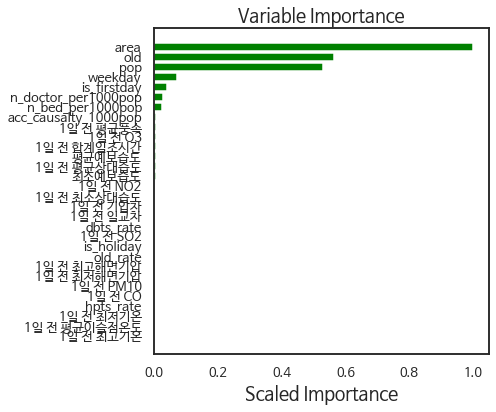

In [140]:
fig, ax = plt.subplots(figsize=(6,6))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")

variables = drf_grid_016.models[0]._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = drf_grid_016.models[0]._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos[:30], scaled_importance[:30], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos[:30])
ax.set_yticklabels(variables[:30])
ax.tick_params(labelsize=13)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')

Text(0.5, 1.0, 'Variable Importance')

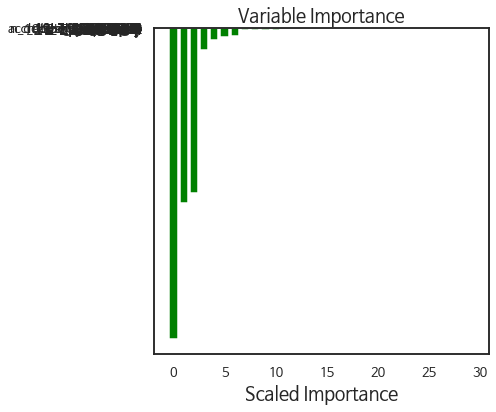

In [145]:
fig, ax = plt.subplots(figsize=(6,6))
fig.patch.set_facecolor('#ffffff')
ax.set_facecolor("#ffffff")

variables = drf_grid_016.models[0]._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = drf_grid_016.models[0]._model_json['output']['variable_importances']['relative_importance']
ax.barh(y_pos[:30], scaled_importance[:30], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos[:30])
ax.set_yticklabels(variables[:30])
ax.tick_params(labelsize=13)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')

In [141]:
drf_grid_016.models[0]._model_json['output']['variable_importances']


Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,area,2.178598e+06,1.000000,0.424661
1,old,1.229026e+06,0.564136,0.239567
2,pop,1.156339e+06,0.530772,0.225398
3,weekday,1.536365e+05,0.070521,0.029947
4,is_firstday,8.658275e+04,0.039742,0.016877
5,n_doctor_per1000pop,5.920745e+04,0.027177,0.011541
6,n_bed_per1000pop,5.248471e+04,0.024091,0.010231
7,acc_causalty_1000pop,1.276058e+04,0.005857,0.002487
8,1일 전 평균풍속,1.071269e+04,0.004917,0.002088
9,1일 전 O3,9.786290e+03,0.004492,0.001908



See the whole table with table.as_data_frame()
